# Creating Model Documentation Using Jupyterbook and Intake-esm

A common step to any project is documenting your data and your data workflow. Fortunately, open tools in the scientific python ecosystem make that much easier! In this example, we will cover creating your github repo, creating the catalog, visualizing the catalog, and generating a static webpage you can share with collaborators!

## Fair Warning
This week's post is quite detailed, so just a warning! If you would like to look at the finished product, check out the following

* [Github repository with the content built here](https://github.com/mgrover1/cesm-test-data)
* [Finished website with content](https://mgrover1.github.io/cesm-test-data/)

By the end of this post, we will cover how to build a webpage that looks like this
![CESM book page](../images/cesm_book_page.png)

## Create your Github Repository

Go to [Github](https://github.com/) and select "New" in the top lefthand corner next to "Repositories" - this will pull up the following window. Once you are here, go ahead and name your repository!

Be sure to add:
* Repository name
* Description
* README
* Gitignore (use the python template)
* Choose a license


![screen_grab](../images/github_screen_grab.png)

## Clone your Repository
At this point, you can go ahead and clone your repository! You can either clone to your local machine, or to some Jupyterhub (such as the [NCAR Jupyterhub](https://jupyterhub.ucar.edu)), which will do in this case.

### Copy the link from Github
Copy the link from Github by clicking on the green "Code" button
![Github Clone Link](../images/github_clone_link.png)

### Clone to your machine!
We want to clone to the repository within the [Jupyterhub](https://jupyterhub.ucar.edu), so once logging on, we open a terminal and paste the link using the following syntax

```bash
git clone https://github.com/mgrover1/cesm-test-data.git
```

## Create a docs directory
Now that you cloned the repository, move into it and create a `docs` directory using the following

```bash
cd cesm-test-data
mkdir docs
```

## Build your Catalog
Open a new Jupyter Notebook called `model_documentation.ipynb` within the `docs` directory and select a development environment which includes the following:
- jupyter-book
- ecgtools

If you haven't installed these yet, you can use conda and pip (ecgtools is not yet on conda-forge)

```bash
conda install -c conda-forge jupyter-book intake-esm graphviz
pip install ecgtools
```

In this case, follow the instructions in the [Building an Intake-esm catalog from CESM2 History Files](https://ncar.github.io/esds/posts/ecgtools-history-files-example/) post provides the instructions for building the data catalog

## Read the Catalog and Visualize the Components and Frequency
A couple weeks ago, we covered [Creating Visualizations of Intake-ESM Catalogs](https://ncar.github.io/esds/posts/graphviz_example/) which is helpful for understanding how [`Graphviz`](https://graphviz.readthedocs.io/en/stable/manual.html) works!

### Imports

In [8]:
import intake
from graphviz import Digraph

### Read in the Test History Catalog

In [9]:
col = intake.open_esm_datastore('/glade/work/mgrover/cesm-hist-test.json')

We will assign the dataframe from the catalog to its own variable

In [10]:
df = col.df

### Visualize the Catalog
Using the `Diagraph` object from the [`Graphviz` library](https://graphviz.readthedocs.io/en/stable/manual.html), we setup a loop to create the visualization using the three categories
* Case
* Component
* Frequency

In [11]:
# Create Digraph object - use the left to right orientation instead of vertical
dot = Digraph(graph_attr={'rankdir': 'LR'})

# Save the catalog as a pdf
dot.format = 'pdf'

# Start counting at one for node numbers
num_node = 1

# Loop through the different cases
for case in df.case.unique():
    case_i = num_node
    dot.node(str(case_i), label=case)
    num_node += 1

    # Loop through the different components in each case
    for component in df.loc[df.case == case].component.unique():
        comp_i = num_node
        dot.node(str(comp_i), label=component)
        dot.edge(str(case_i), str(comp_i))
        num_node += 1

        # Loop through the frequency in each component within each experiment
        for frequency in df.loc[(df.case == case) & (df.component == component)].frequency.unique():
            freq_i = num_node

            # Pull out the the stream information
            stream = df.loc[
                (df.case == case) & (df.component == component) & (df.frequency == frequency)
            ].stream.values[0]

            # Add both stream and frequency information to these bubbles
            dot.node(str(freq_i), label=f'stream: {stream} \n frequency: {frequency}')
            dot.edge(str(comp_i), str(freq_i))
            num_node += 1
        comp_i += 1
    case_i += 1

Now visualize it in inline by running a cell with just the `dot` object

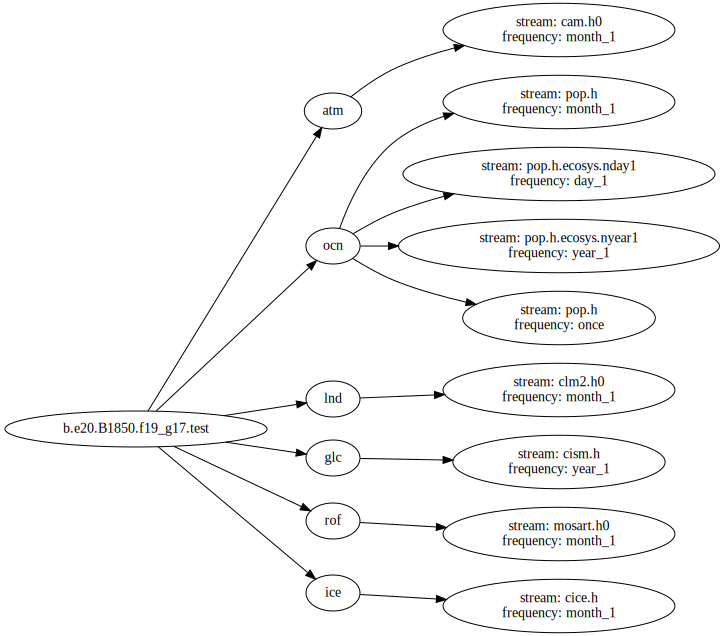

In [12]:
dot

### Save the Visualization
In the block of code above, we specified `dot.format = 'pdf'` which will ensure that when we save the graph, it is in PDF format. Other options include (but not limited to) `svg` and `png`!

The `Diagraph` method for saving is `.render()` with the filename in the argument (within the parentheses)

In [13]:
dot.render('cesm_test_catalog')

'cesm_test_catalog.pdf'

This saved a file within your directory called `cesm_test_catalog.pdf`! You can double click this within your file browser to take a look

## Add Jupyterbook files
If you are curious about [Jupyterbook](https://jupyterbook.org/intro.html), be sure to checkout their [official documentation](https://jupyterbook.org/intro.html), specifically their [building your first book](https://jupyterbook.org/start/your-first-book.html) tutorial!

The main two files we need now are
* The table of contents (`_toc.yml`)
* The config file (`_config.yml`)

Go ahead and create text files with your docs directory using those identical filenames

### Download a sample CESM logo
I copied over a copy of the CESM logo to Github, which can be downloaded using the following (be sure to save to an an `image` directory in `docs`

```bash
wget https://raw.githubusercontent.com/mgrover1/cesm-workflow/main/images/cesm.jpg
```

### Adding to your Config (`_config.yml`) file
Within your `_config.yml` file, input the following

```bash
title: "CESM Test Data"
logo: images/cesm.jpg
execute:
  execute_notebooks: "off"
```

### Add to your Table of Contents (`_toc.yml`) file

This is where you place your content - in this case, the `model_documentation.ipynb` notebook. Jupyterbook does not require you specify the file type here - so leave off the `.ipynb`
```bash
- file: model_documentation
```

## Build your Book!
Now that you have your content, config file, and table of contents, it's time to build the book. Make sure you are in your repository root directory, and run the following
```bash
jupyter-book build docs
```

If it built correctly, you should see the following
```
===============================================================================

Finished generating HTML for book.
Your book's HTML pages are here:
    docs/_build/html/
You can look at your book by opening this file in a browser:
    docs/_build/html/index.html
Or paste this line directly into your browser bar:
    file:///glade/work/mgrover/git_repos/cesm-test-data/docs/_build/html/index.html            

===============================================================================
```

## View the Book on Github
It can be difficult to view the book on the Jupyterhub, but fortunately we can use Github for publishing this online!

The [Jupyterbook publish your book online](https://jupyterbook.org/start/publish.html) docs are helpful here, so we use the second part here [describing using Github Pages](https://jupyterbook.org/start/publish.html#publish-your-book-online-with-github-pages)

### Install Github Pages Import

If you have not done so already, install the following

```bash
pip install ghp-import
```

### Build the book and push to your Github Pages branch

Move to your docs directory again, and run the following (after building your book)

```bash
ghp-import -n -p -f _build/html
```

### Rebuilding your book
If you make changes to your notebook or want to rebuild your book, run the following within your project root directory
```bash
jupyter-book build docs
```

and this within your `docs` directory
```bash
ghp-import -n -p -f _build/html
```

## Go checkout your book!
Your book will be published along the following url structure


`{github_username}.github.io/{repository_name}`

For this example, the book can be found here

[**https://mgrover1.github.io/cesm-test-data/**](https://mgrover1.github.io/cesm-test-data/)

## Conclusion
This was a fairly in-depth post which covered content from previous [ESDS blog posts](https://ncar.github.io/esds/blog/), but I hope this provides a starting point for documentation your data, visualizing the data available, and sharing your data documentation with others!